In [18]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Dropout
import matplotlib.pyplot as plt

In [19]:
import yfinance as yf
#override pandas_datareader's default methods to fetch data
yf.pdr_override()
from pandas_datareader import data as pdr

stock_symbol='D05.SI'
#get 8 years of daily stock data
df = pdr.get_data_yahoo(stock_symbol, start='2014-01-01', end='2021-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Exploration

In [20]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,15.636363,15.654545,15.500000,15.545454,10.016028,2033900
2014-01-03,15.518181,15.545454,15.336363,15.436363,9.945743,2733500
2014-01-06,15.436363,15.481818,15.372727,15.472727,9.969171,1372800
2014-01-07,15.518181,15.581818,15.409090,15.490909,9.980885,3883000
2014-01-08,15.581818,15.809090,15.554545,15.790909,10.174178,6241400
...,...,...,...,...,...,...
2021-12-24,29.609091,29.645454,29.518181,29.645454,26.032339,1155000
2021-12-27,29.636362,29.681818,29.545454,29.545454,25.944530,672980
2021-12-28,29.636362,29.772726,29.572727,29.772726,26.144102,1723920


In [21]:
df.shape

(2011, 6)

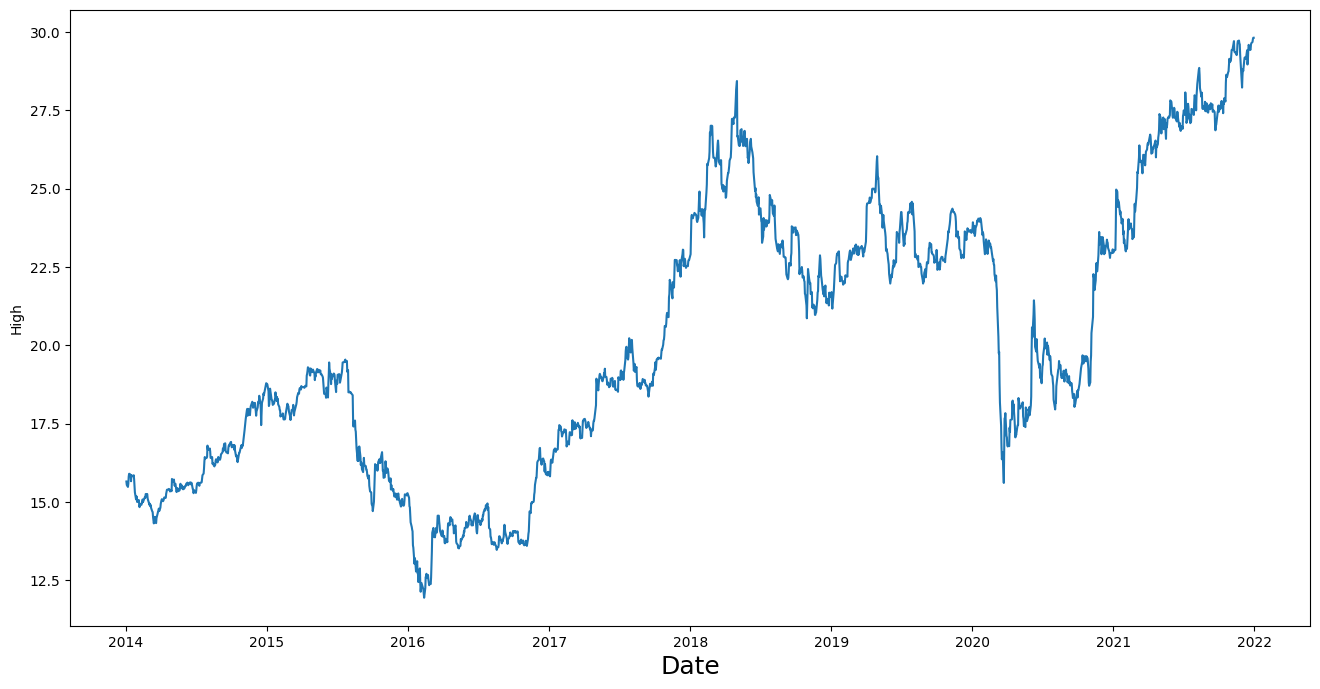

In [22]:
#plot the daily high prices to visualize trends over time
plt.figure(figsize=(16,8))
plt.plot(df[['High']])
plt.xlabel('Date', fontsize =18)
plt.ylabel('High')
plt.show()

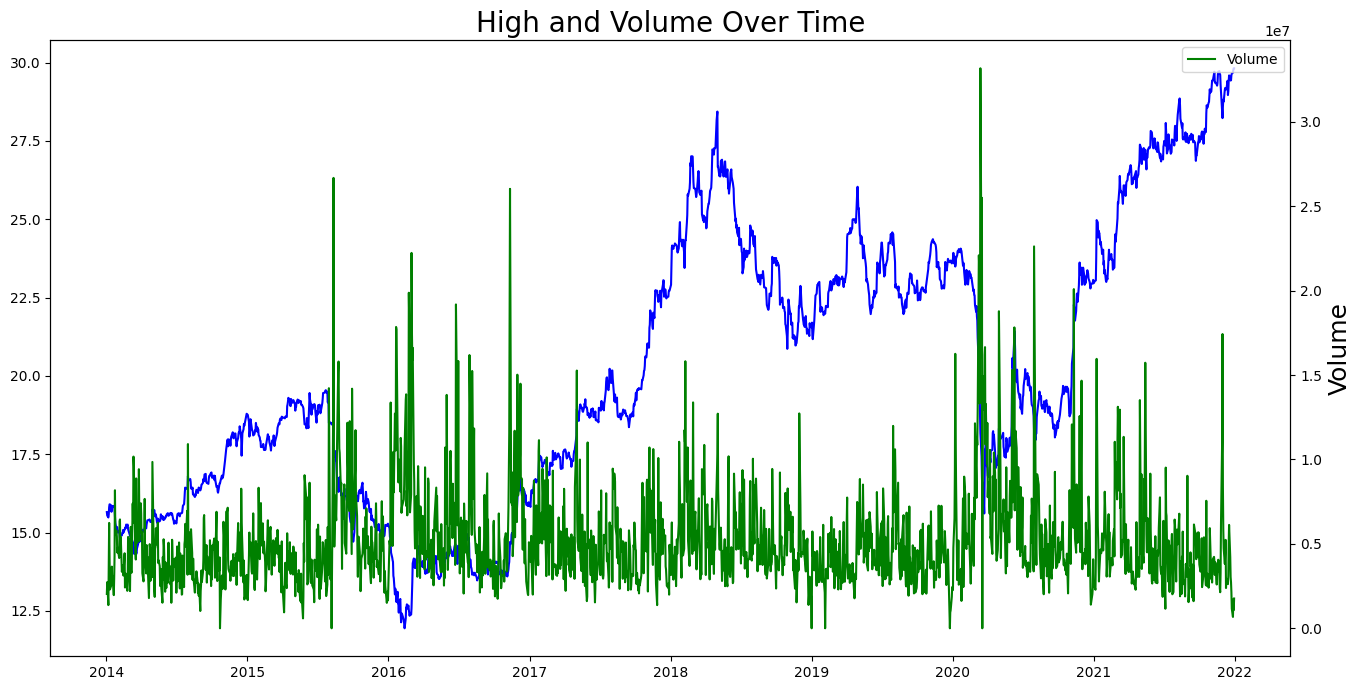

In [23]:
#plot high prices and volume on the same chart for correlation analysis 
plt.figure(figsize=(16,8))

plt.plot(df['High'], label='High', color='blue')


ax2 = plt.gca().twinx()
ax2.plot(df['Volume'], label='Volume', color='green')


plt.xlabel('Date', fontsize=18)
plt.ylabel('High', fontsize=18)
ax2.set_ylabel('Volume', fontsize=18)

plt.title('High and Volume Over Time', fontsize=20)
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Data Preprocessing

In [24]:
data = df.filter(['High','Volume'])
data_keep = df.filter(['High','Volume']).copy()

In [25]:
#scale the high and volume data for LSTM input
scaler_high = MinMaxScaler()
scaler_volume = MinMaxScaler()
scaler_high.fit(data[['High']])
scaler_volume.fit(data[['Volume']])
data['High'] = scaler_high.transform(data[['High']])
data['Volume'] = scaler_volume.transform(data[['Volume']])

In [26]:
scaled_data = data.values
scaled_data

array([[0.207528  , 0.06130108],
       [0.20142424, 0.0823868 ],
       [0.19786374, 0.04137574],
       ...,
       [0.99745679, 0.05195839],
       [1.        , 0.03244747],
       [1.        , 0.05315523]])

In [27]:
training_data_len = (len(scaled_data))
training_data_len

2011

In [28]:
train_data = scaled_data[0:training_data_len, :]
train_data

array([[0.207528  , 0.06130108],
       [0.20142424, 0.0823868 ],
       [0.19786374, 0.04137574],
       ...,
       [0.99745679, 0.05195839],
       [1.        , 0.03244747],
       [1.        , 0.05315523]])

In [29]:
train_data.shape

(2011, 2)

Model Training

In [30]:
#prepare data for LSTM model by creating sequences of 52 days for training
x_train = []
y_train = []
sequence_length = 52

for i in range(len(train_data) - sequence_length):
    x_train.append(train_data[i:i + sequence_length])
    y_train.append(train_data[i + sequence_length][0])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train

array([[[0.207528  , 0.06130108],
        [0.20142424, 0.0823868 ],
        [0.19786374, 0.04137574],
        ...,
        [0.13835202, 0.28886767],
        [0.13275688, 0.23326902],
        [0.14445578, 0.13957683]],

       [[0.20142424, 0.0823868 ],
        [0.19786374, 0.04137574],
        [0.20345883, 0.11703235],
        ...,
        [0.13275688, 0.23326902],
        [0.14445578, 0.13957683],
        [0.13936931, 0.12280108]],

       [[0.19786374, 0.04137574],
        [0.20345883, 0.11703235],
        [0.21617497, 0.18811376],
        ...,
        [0.14445578, 0.13957683],
        [0.13936931, 0.12280108],
        [0.13377417, 0.26758303]],

       ...,

       [[0.8819939 , 0.09844974],
        [0.89216693, 0.11352138],
        [0.88606318, 0.07676394],
        ...,
        [0.98779259, 0.06419871],
        [0.9903358 , 0.03481132],
        [0.99237038, 0.0202834 ]],

       [[0.89216693, 0.11352138],
        [0.88606318, 0.07676394],
        [0.9196339 , 0.22768594],
        .

In [31]:
x_train.shape

(1959, 52, 2)

In [32]:
y_train

array([0.13936931, 0.13377417, 0.13326555, ..., 0.99745679, 1.        ,
       1.        ])

In [33]:
y_train.shape

(1959,)

In [34]:
#build LSTM model architecture
model = Sequential()
model.add(InputLayer(input_shape=(sequence_length, 2)))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

C:\Users\Pravin M\Desktop\stock-prediction_LTSM\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [35]:
#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [36]:
#train the model
model.fit(x_train,y_train, batch_size=16, epochs = 50,validation_split=0.2)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0315 - val_loss: 0.0016
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0011 - val_loss: 8.6674e-04
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0010 - val_loss: 9.0826e-04
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.2692e-04 - val_loss: 8.3211e-04
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 8.0147e-04 - val_loss: 6.5531e-04
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 8.5753e-04 - val_loss: 5.6909e-04
Epoch 12/50
98/98 ━━━━━━━━━━━━━

Testing and Evaluation

In [37]:
#assuming test dataset cannot take any data from the train dataset period. meaning there will be a gap of 52days
#prepare the test dataset from 2022 data
df_test = pdr.get_data_yahoo(stock_symbol, start='2022-01-01', end='2023-12-31')
df_test

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,29.818180,29.845453,29.745455,29.809090,26.176033,1771660
2022-01-04,30.045454,30.709089,30.009090,30.645454,26.910465,5813720
2022-01-05,30.727272,30.772726,30.063637,30.218182,26.535263,5120060
2022-01-06,29.981817,30.745455,29.963636,30.745455,26.998276,5170110
2022-01-07,31.045454,31.245455,30.945454,31.245455,27.437338,5531460
...,...,...,...,...,...,...
2023-12-22,28.909090,29.136362,28.863636,29.090908,28.225021,5476130
2023-12-26,29.172728,29.181818,28.954544,29.000000,28.136820,1202520
2023-12-27,29.136362,29.463636,29.027271,29.400000,28.524914,3089900


In [38]:
data_test = df_test.filter(['High','Volume'])
test_keep = df_test.filter(['High','Volume'])

In [39]:
data_test['High'] = scaler_high.transform(data_test[['High']])
data_test['Volume'] = scaler_volume.transform(data_test[['Volume']])

In [40]:
scaled_data_test = data_test.values
scaled_data_test

array([[1.00152597, 0.05339725],
       [1.04984741, 0.17522362],
       [1.05340797, 0.15431694],
       [1.05188211, 0.15582543],
       [1.07985769, 0.1667164 ],
       [1.12105804, 0.20610955],
       [1.13987793, 0.22038551],
       [1.14750766, 0.21648333],
       [1.14445594, 0.12572192],
       [1.15666324, 0.13401365],
       [1.16429297, 0.13572968],
       [1.16937959, 0.13992162],
       [1.16785352, 0.145421  ],
       [1.16225849, 0.16322863],
       [1.15462876, 0.22680737],
       [1.15513738, 0.10004443],
       [1.14242124, 0.21092015],
       [1.14445594, 0.16707446],
       [1.12970511, 0.18896581],
       [1.12207538, 0.30851452],
       [1.13987793, 0.14898251],
       [1.17243152, 0.22681732],
       [1.16225849, 0.12050685],
       [1.18718214, 0.15768535],
       [1.20651076, 0.1762547 ],
       [1.21363187, 0.10727855],
       [1.21414049, 0.12200208],
       [1.23601221, 0.2004436 ],
       [1.23855552, 0.16749219],
       [1.21007131, 0.22383017],
       [1.

In [41]:
#prepare sequences for testing the model
x_test = []
y_test = []

sequence_length = 52

for i in range(len(scaled_data_test) - sequence_length):
    x_test.append(scaled_data_test[i:i + sequence_length])
    y_test.append(scaled_data_test[i + sequence_length][0])

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test

array([[[1.00152597, 0.05339725],
        [1.04984741, 0.17522362],
        [1.05340797, 0.15431694],
        ...,
        [1.06561559, 0.21140419],
        [1.09562566, 0.172694  ],
        [1.12410986, 0.19178055]],

       [[1.04984741, 0.17522362],
        [1.05340797, 0.15431694],
        [1.05188211, 0.15582543],
        ...,
        [1.09562566, 0.172694  ],
        [1.12410986, 0.19178055],
        [1.10986787, 0.27290751]],

       [[1.05340797, 0.15431694],
        [1.05188211, 0.15582543],
        [1.07985769, 0.1667164 ],
        ...,
        [1.12410986, 0.19178055],
        [1.10986787, 0.27290751],
        [1.12207538, 0.10658564]],

       ...,

       [[1.07121062, 0.14453661],
        [1.05696852, 0.09613561],
        [1.03509669, 0.07515267],
        ...,
        [0.9526959 , 0.13005796],
        [0.96185148, 0.16504877],
        [0.9643948 , 0.03624356]],

       [[1.05696852, 0.09613561],
        [1.03509669, 0.07515267],
        [1.05289935, 0.07160855],
        .

In [42]:
x_test.shape

(447, 52, 2)

In [43]:
y_test

array([1.10986787, 1.12207538, 1.12054942, 1.13021373, 1.14445594,
       1.15208545, 1.17090545, 1.17802655, 1.17599186, 1.1765007 ,
       1.14903373, 1.14903373, 1.15869793, 1.15717207, 1.1459818 ,
       1.11698886, 1.07731449, 1.06256366, 1.05849449, 1.05086476,
       1.02644973, 1.04120045, 1.0305189 , 1.04069183, 1.04577824,
       1.05798587, 1.04069183, 1.01322486, 1.01780266, 1.0824009 ,
       1.08036631, 1.08647007, 1.02746697, 1.01882   , 0.98982707,
       0.9643948 , 0.93896242, 0.94201435, 0.9338759 , 0.93285866,
       0.92573766, 0.92166838, 0.92828086, 0.90742628, 0.89369279,
       0.9125128 , 0.92522893, 0.92624628, 0.94659214, 0.92726352,
       0.92472031, 0.92370297, 0.91403876, 0.90539169, 0.90233986,
       0.88758904, 0.87334693, 0.86266538, 0.85961345, 0.86520859,
       0.88504583, 0.86419135, 0.86368273, 0.87232969, 0.88402859,
       0.87639886, 0.85757886, 0.87080373, 0.87029511, 0.87436428,
       0.86520859, 0.84486273, 0.86368273, 0.86775179, 0.87385

In [44]:
y_test.shape

(447,)

In [45]:
#make predictions and evaluate the model
predictions = model.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [46]:
predictions.shape

(447, 1)

In [47]:
inverse_predictions = scaler_high.inverse_transform(predictions)

In [48]:
len(inverse_predictions)

447

In [49]:
rmse=np.sqrt(np.mean(((inverse_predictions- y_test)**2)))
rmse

29.036257936425784

In [50]:
#plot predictions against actual values
valid = test_keep[52:].copy()
valid['Predictions'] = inverse_predictions
valid

,High,Volume,Predictions
Date,,,
2022-03-18,31.781818,9054760,31.846310
2022-03-21,32.000000,3536390,31.551434
2022-03-22,31.972727,2891790,31.733931
2022-03-23,32.145454,3071530,31.789930
2022-03-24,32.400002,3315620,31.965147
...,...,...,...
2023-12-22,29.136362,5476130,28.910521
2023-12-26,29.181818,1202520,29.040060
2023-12-27,29.463636,3089900,29.166208


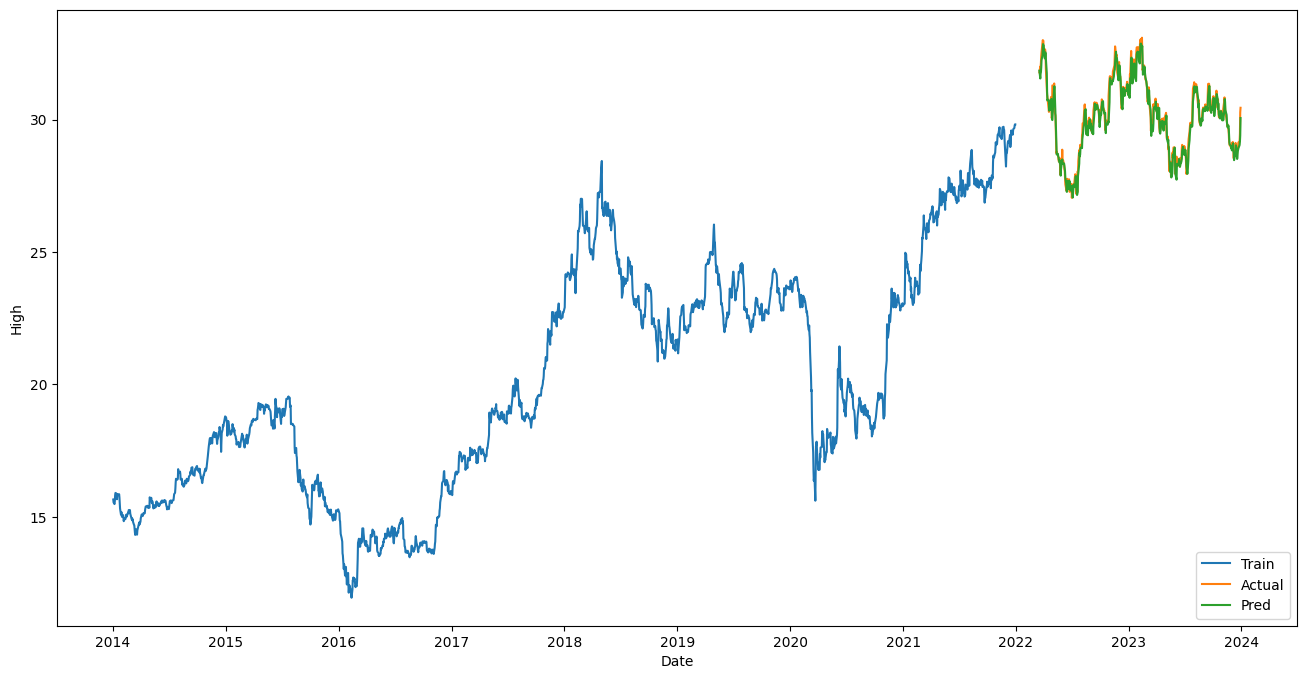

In [51]:
plt.figure(figsize = (16,8))
plt.xlabel('Date')
plt.ylabel('High')
plt.plot(df['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Train','Actual','Pred'], loc = 'lower right')
plt.show()

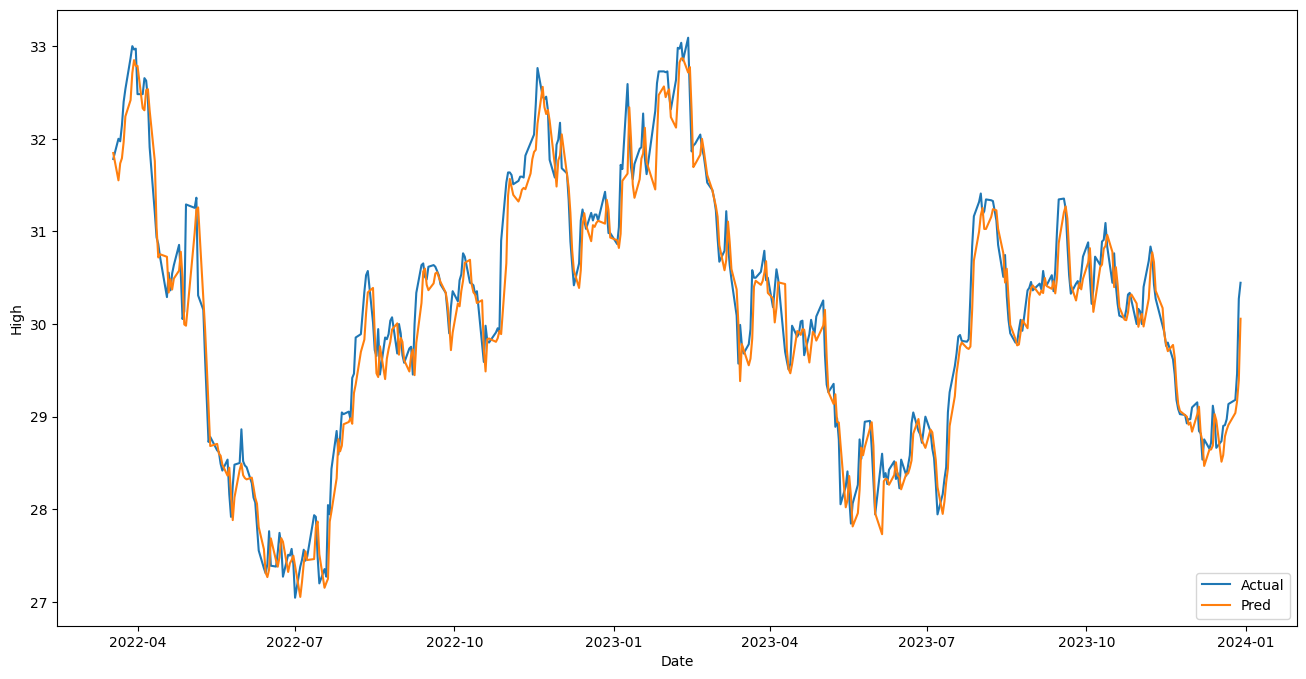

In [52]:
plt.figure(figsize = (16,8))
plt.xlabel('Date')
plt.ylabel('High')
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Actual','Pred'], loc = 'lower right')
plt.show()